In [1]:
import sys
print(sys.executable)

/Users/shari/Desktop/github/fanduel-casestudy/.venv/bin/python


In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
print(pd.__version__)

2.3.3


## Set-up & Data cleaning:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

# --- Load data (relative path, reproducible) ---
REPO_ROOT = Path.cwd().parent

DATA_PATH = REPO_ROOT / "data" / "FanDuel_CaseStudy_BusinessDataAnalysis.csv"
df_raw = pd.read_csv(DATA_PATH)

df_raw.head(), list(df_raw.columns)

(   playerid      date    handle     ggr last_12months_segment Target/CG  \
 0   1368045  2/6/2020  11350.00  257.00                  high    Target   
 1   1158039  2/6/2020   4819.45  735.85                   vip    Target   
 2   1237973  2/6/2020   4486.85  816.61                medium    Target   
 3   1305477  2/6/2020   2186.88 -156.36                   low    Target   
 4   1272983  2/6/2020   2178.70   28.04                  high    Target   
 
    bonus awarded Post Promo In-Analysis     Handle Bin  
 0           20.0        Yes         Yes   $10K–$24,999  
 1           50.0        Yes         Yes  $3,500–$4,999  
 2           10.0        Yes         Yes  $3,500–$4,999  
 3            5.0        Yes         Yes  $1,500–$2,499  
 4           20.0        Yes         Yes  $1,500–$2,499  ,
 ['playerid',
  'date',
  'handle',
  'ggr',
  'last_12months_segment',
  'Target/CG',
  'bonus awarded',
  'Post Promo',
  'In-Analysis',
  'Handle Bin'])

In [4]:
import re

def normalize_columns(cols):
    out = []
    for c in cols:
        c = c.strip().lower()
        c = c.replace(" ", "_").replace("-", "_")
        c = re.sub(r"[^a-z0-9_]", "", c)       # drop weird characters
        c = re.sub(r"_+", "_", c)              # collapse multiple underscores
        c = c.strip("_")
        out.append(c)
    return out

def clean_df(df):
    d = df.copy()

    # 1) Normalize ALL column names to snake_case
    d.columns = normalize_columns(d.columns)

    # 2) Map common header variations into canonical schema
    rename_map = {
        "targetcg": "target_control",
        "target_cg": "target_control",
        "targetcontrol": "target_control",
        "target_control": "target_control",
        "targetcontrolgroup": "target_control",
        "target_control_group": "target_control",
        "target_group": "target_control",
        "control_group": "target_control",

        "playerid": "player_id",
        "player_id": "player_id",

        "bonus_award": "bonus_awarded",
        "bonus_awarded": "bonus_awarded",

        "postpromo": "post_promo",
        "post_promo": "post_promo",

        "last__12months_segment": "last_12months_segment",
        "last_12months_segment": "last_12months_segment",

        "handlebin": "handle_bin",
        "handle_bin": "handle_bin",

        "date": "date",
        "ggr": "ggr",
        "handle": "handle",
    }
    d = d.rename(columns={k: v for k, v in rename_map.items() if k in d.columns})

    # 3) Coerce types
    for col in ["ggr", "handle", "bonus_awarded"]:
        if col in d.columns:
            d[col] = pd.to_numeric(d[col], errors="coerce")

    if "date" in d.columns:
        d["date"] = pd.to_datetime(d["date"], errors="coerce")

    # 4) Standardize post_promo to boolean
    if "post_promo" in d.columns:
        d["post_promo"] = (
            d["post_promo"]
            .astype(str).str.strip().str.lower()
            .map({"yes": True, "no": False, "true": True, "false": False, "1": True, "0": False})
        )

    # 5) Standardize target_control labels
    if "target_control" in d.columns:
        x = d["target_control"].astype(str).str.strip().str.lower()
        x = x.replace({
            "control group": "control",
            "cg": "control",
            "control": "control",
            "target group": "target",
            "tg": "target",
            "target": "target",
        })
        d["target_control"] = x

    return d

df = clean_df(df_raw)

# Sanity checks
display(df.head())
print("Columns:", df.columns.tolist())
print("target_control:", df["target_control"].dropna().unique() if "target_control" in df.columns else None)
print("post_promo:", df["post_promo"].dropna().unique() if "post_promo" in df.columns else None)

,player_id,date,handle,ggr,last_12months_segment,target_control,bonus_awarded,post_promo,in_analysis,handle_bin
0,1368045,2020-02-06,11350.00,257.00,high,target,20.0,True,Yes,"$10K–$24,999"
1,1158039,2020-02-06,4819.45,735.85,vip,target,50.0,True,Yes,"$3,500–$4,999"
2,1237973,2020-02-06,4486.85,816.61,medium,target,10.0,True,Yes,"$3,500–$4,999"
3,1305477,2020-02-06,2186.88,-156.36,low,target,5.0,True,Yes,"$1,500–$2,499"
4,1272983,2020-02-06,2178.70,28.04,high,target,20.0,True,Yes,"$1,500–$2,499"


Columns: ['player_id', 'date', 'handle', 'ggr', 'last_12months_segment', 'target_control', 'bonus_awarded', 'post_promo', 'in_analysis', 'handle_bin']
target_control: ['target' 'control']
post_promo: [ True False]


In [5]:
# --- Validation checks ---
required = ["player_id", "date", "target_control", "post_promo", "ggr", "handle", "bonus_awarded"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# 1) No null player_id
if df["player_id"].isna().any():
    print("WARNING: Null player_id rows:", df["player_id"].isna().sum())

# 2) Check date parsing success
if df["date"].isna().any():
    print("WARNING: Unparsed date rows:", df["date"].isna().sum())

# 3) Bonus should be one per player (or at least not repeated with conflicting values)
bonus_by_player = df.groupby("player_id", dropna=False)["bonus_awarded"].nunique()
repeated_bonus_players = (bonus_by_player > 1).sum()
print("Players with >1 distinct bonus_awarded values:", repeated_bonus_players)

# 4) Confirm analysis windows exist
print("Min date:", df["date"].min(), "Max date:", df["date"].max())
print(df.groupby("post_promo")["date"].agg(["min","max","count"]))

Players with >1 distinct bonus_awarded values: 0
Min date: 2019-01-21 00:00:00 Max date: 2020-02-06 00:00:00
                  min        max  count
post_promo                             
False      2019-01-21 2020-01-20  11470
True       2020-01-21 2020-02-06    711


## Method & Caveats: How to interpret results

### Method choices
- **Unit of analysis (player-level):** Aggregate transactions to **per-player totals** in matched pre/post windows to avoid row-count bias and to align outcomes with CRM targeting.
- **Window design (matched length):** Define a **17-day post window** (promo period) and a **matched 17-day pre window** immediately preceding it to keep pre/post comparisons comparable.
- **Causal read-out (primary):** Use **Difference-in-Differences (DiD)** to estimate incremental impact:
  - $\Delta = (Target_{post}-Target_{pre}) - (Control_{post}-Control_{pre})$
  - This controls for baseline differences between target/control and shared time trends.
- **Bonus accounting (count once per player):** Treat promo spend as **one bonus per targeted player** (player-level `max(bonus_awarded)`), summed over the target group to avoid row-level double counting.
- **Profitability lens:**
  - **DiD incremental GGR (Δ)**
  - **Net-after-bonus:** $\Delta - BonusCost$, plus **DiD ROI** as the primary ROI metric.
- **Uncertainty quantification:** Use **bootstrap resampling of players** (within group / within segment) to compute **95% confidence intervals** for Δ and ROI.
- **Segmentation strategy:** Produce **segment-level DiD ROI + CI** (by `last_12months_segment`) and pair it with **retention/attrition decomposition** (retained/churned/reactivated/inactive) to inform CRM rollout decisions.

### Caveats / limitations
- **Parallel trends is assumed:** DiD relies on target and control having similar underlying trends absent the promo. This is partially addressed by using matched windows and a control group, but this assumption should be checked with pre-trend diagnostics.
- **Small control in some segments:** Several segments have very small control counts, leading to **wide CIs**; treat these as **directional** and use the CRM calls (`SCALE/STOP/HOLD/INSUFFICIENT`) rather than point estimates alone.
- **Short measurement window:** A 17-day post window may miss longer-term effects (true retention/LTV). Results should be interpreted as **short-run incremental impact**.
- **GGR vs true profit:** GGR is a proxy for margin and does not include all costs (e.g., operating costs, risk, chargebacks). Net-after-bonus improves interpretability but is not full P&L.
- **Outliers can dominate totals:** A small number of high-volume players can drive segment results; robustness checks (winsorization / trimming) are recommended before finalizing scale decisions.

## Matched windows & Player aggregation:

In [6]:
import pandas as pd
import numpy as np

# --- Identify post-window from the data ---
post_dates = df.loc[df["post_promo"] == True, "date"].dropna()
if post_dates.empty:
    raise ValueError("No post_promo == True rows found. Cannot define post window.")

post_start = post_dates.min().normalize()
post_end   = post_dates.max().normalize()

# Inclusive day count
post_days = (post_end - post_start).days + 1

# Matched pre-window: immediately preceding post-window with same length
pre_end   = (post_start - pd.Timedelta(days=1)).normalize()
pre_start = (pre_end - pd.Timedelta(days=post_days - 1)).normalize()

print("Post window:", post_start.date(), "to", post_end.date(), f"({post_days} days)")
print("Pre  window:", pre_start.date(), "to", pre_end.date(), f"({post_days} days)")

Post window: 2020-01-21 to 2020-02-06 (17 days)
Pre  window: 2020-01-04 to 2020-01-20 (17 days)


In [7]:
def label_window(d):
    d = d.copy()
    d["date"] = pd.to_datetime(d["date"]).dt.normalize()

    d["window"] = np.select(
        [
            (d["date"] >= pre_start) & (d["date"] <= pre_end),
            (d["date"] >= post_start) & (d["date"] <= post_end),
        ],
        ["pre", "post"],
        default="out"
    )
    return d

dw = label_window(df)
dw = dw.loc[dw["window"].isin(["pre", "post"])].copy()

print(dw["window"].value_counts())
print("Date range in dw:", dw["date"].min().date(), "to", dw["date"].max().date())

window
pre     788
post    711
Name: count, dtype: int64
Date range in dw: 2020-01-04 to 2020-02-06


In [8]:
# Aggregate to player-window level
agg = (dw
       .groupby(["player_id", "target_control", "window"], dropna=False)
       .agg(
           ggr=("ggr", "sum"),
           handle=("handle", "sum"),
           active_days=("date", "nunique")  # how many distinct days the player was active in window
       )
       .reset_index()
)

# Pivot to one row per player with pre/post columns
player = (agg
          .pivot_table(index=["player_id", "target_control"],
                       columns="window",
                       values=["ggr", "handle", "active_days"],
                       fill_value=0,
                       aggfunc="sum")
          .reset_index())

# Flatten columns
player.columns = [
    f"{a}_{b}" if b else a
    for a, b in player.columns.to_flat_index()
]

# Define activity flags
player["active_pre"]  = player["active_days_pre"]  > 0
player["active_post"] = player["active_days_post"] > 0

player.head()

,player_id,target_control,active_days_post,active_days_pre,ggr_post,ggr_pre,handle_post,handle_pre,active_pre,active_post
0,1128453,target,0,2,0.00,49.94,0.00,186.40,True,False
1,1128604,target,1,3,20.00,79.92,94.00,316.60,True,True
2,1130293,target,0,2,0.00,399.82,0.00,4075.80,True,False
3,1131401,target,8,12,69.99,-68.85,3895.79,3454.74,True,True
4,1132221,target,1,0,0.12,0.00,0.20,0.00,False,True


In [9]:
# Bonus is one per customer; compute from player-level unique rows
bonus_player = (df.groupby(["player_id", "target_control"], dropna=False)
                  .agg(bonus_awarded=("bonus_awarded", "max"))
                  .reset_index())

# Treat missing bonus as 0
bonus_player["bonus_awarded"] = bonus_player["bonus_awarded"].fillna(0)

# Merge into player table
player = player.merge(bonus_player, on=["player_id", "target_control"], how="left")
player["bonus_awarded"] = player["bonus_awarded"].fillna(0)

# Sanity check: bonus should not vary by date
players_with_multiple_bonus_values = (df.groupby("player_id")["bonus_awarded"].nunique() > 1).sum()
print("Players with >1 distinct bonus_awarded values:", players_with_multiple_bonus_values)

player[["player_id", "target_control", "bonus_awarded"]].head()

Players with >1 distinct bonus_awarded values: 0


,player_id,target_control,bonus_awarded
0,1128453,target,5.0
1,1128604,target,10.0
2,1130293,target,5.0
3,1131401,target,10.0
4,1132221,target,10.0


In [10]:
# --- Bonus sanity checks ---

# Players with >1 distinct bonus_awarded values
players_multi_bonus_values = (df.groupby("player_id")["bonus_awarded"].nunique(dropna=True) > 1).sum()
print("Players with >1 distinct bonus_awarded values:", players_multi_bonus_values)

# Players with >1 non-null bonus rows (duplicates can repeat same value)
players_multi_bonus_rows = (df[df["bonus_awarded"].notna()]
                            .groupby("player_id")
                            .size()
                            .gt(1)
                            .sum())
print("Players with >1 non-null bonus_awarded rows:", players_multi_bonus_rows)

# Optional to see examples (only if count > 0)
if players_multi_bonus_rows > 0:
    dup_bonus_examples = (df[df["bonus_awarded"].notna()]
                          .groupby("player_id")
                          .filter(lambda g: len(g) > 1)
                          .sort_values(["player_id", "date"])
                          [["player_id","date","target_control","bonus_awarded"]]
                          .head(20))
    display(dup_bonus_examples)

# Sanity check: bonus only expected for target; check if control has bonus recorded
control_bonus_total = df.loc[df["target_control"] == "control", "bonus_awarded"].fillna(0).sum()
print("Total bonus in control group (should be ~0):", control_bonus_total)

Players with >1 distinct bonus_awarded values: 0
Players with >1 non-null bonus_awarded rows: 290


,player_id,date,target_control,bonus_awarded
12167,1128453,2019-01-21,target,5.0
12130,1128453,2019-01-22,target,5.0
11387,1128453,2019-02-13,target,5.0
10909,1128453,2019-03-01,target,5.0
9910,1128453,2019-03-27,target,5.0
8931,1128453,2019-04-25,target,5.0
7948,1128453,2019-05-27,target,5.0
7909,1128453,2019-05-28,target,5.0
7783,1128453,2019-06-01,target,5.0
5834,1128453,2019-08-03,target,5.0


Total bonus in control group (should be ~0): 0.0


In [11]:
def summarize_group(p, group_label):
    g = p.loc[p["target_control"] == group_label].copy()

    # totals
    ggr_post = g["ggr_post"].sum()
    bonus = g["bonus_awarded"].sum()

    return pd.Series({
        "players": len(g),
        "ggr_post_total": ggr_post,
        "bonus_total": bonus,
        "naive_roi": (ggr_post - bonus) / bonus if bonus > 0 else np.nan
    })

naive_target = summarize_group(player, "target")
naive_control = summarize_group(player, "control")

naive = pd.DataFrame([naive_target, naive_control], index=["target", "control"])
naive

,players,ggr_post_total,bonus_total,naive_roi
target,161.0,5826.55,1480.0,2.936858
control,41.0,5941.82,0.0,NaN


## ROI of the Promo — Formula, Inputs, and Read-out (DiD + Matched Windows)

### Goal
Quantify **incremental GGR attributable to the promo** by comparing how Target vs Control changes from a matched **pre window** to the **post window**, then compare incremental value to **bonus spend**.

---

### Definitions (player-level, matched windows)
For each player \(i\), compute window totals:
- $GGR_{i,pre}$: player GGR in the matched pre window  
- $GGR_{i,post}$: player GGR in the post window (promo period)

Aggregate to group totals (Target and Control):
- $Target_{pre} = \sum_{i \in Target} GGR_{i,pre}$
- $Target_{post} = \sum_{i \in Target} GGR_{i,post}$
- $Control_{pre} = \sum_{i \in Control} GGR_{i,pre}$
- $Control_{post} = \sum_{i \in Control} GGR_{i,post}$

Bonus accounting:
- $BonusCost = \sum_{i \in Target} Bonus_i$ where $Bonus_i$ is counted **once per player** (to avoid row-level double counting).

---

### Primary causal estimate (Difference-in-Differences)
**Incremental GGR (DiD):**
$$
\Delta = (Target_{post} - Target_{pre}) - (Control_{post} - Control_{pre})
$$

This adjusts for:
- baseline level differences between Target and Control.  
- common time effects that move both groups similarly.

---

### Profitability read-outs
**Net-after-bonus (incremental net value):**
$$
Net = \Delta - BonusCost
$$

**DiD ROI (primary ROI metric):**
$$
ROI_{DiD} = \frac{\Delta - BonusCost}{BonusCost}
$$

---

### Uncertainty (decision-grade reporting)
Because player outcomes are noisy and sample sizes can be small (especially in segments), we report:
- $\Delta$ with a **95% bootstrap confidence interval**
- $ROI_{DiD}$ with a **95% bootstrap confidence interval**

Interpretation guidance:
- If the ROI CI is **entirely above 0** → evidence to **scale**
- If the ROI CI is **entirely below 0** → evidence to **stop**
- If the ROI CI crosses 0 → **hold / retest** (insufficient evidence)

---

### Note on “naive” post-only ROI
A post-only Target vs Control comparison can be reported as a descriptive sanity check, but the **primary decision metric** in this analysis is the matched-window **DiD ROI** detailed above.

In [12]:
def group_deltas(p):
    out = {}
    for grp in ["target", "control"]:
        g = p.loc[p["target_control"] == grp]
        out[f"{grp}_ggr_pre"] = g["ggr_pre"].sum()
        out[f"{grp}_ggr_post"] = g["ggr_post"].sum()
        out[f"{grp}_delta"] = out[f"{grp}_ggr_post"] - out[f"{grp}_ggr_pre"]
        out[f"{grp}_players"] = len(g)
        out[f"{grp}_bonus"] = g["bonus_awarded"].sum()
    return out

d = group_deltas(player)

did_incremental_ggr = d["target_delta"] - d["control_delta"]
bonus_cost = d["target_bonus"]  # only target gets promo

did_roi = (did_incremental_ggr - bonus_cost) / bonus_cost if bonus_cost > 0 else np.nan

result = {
    "post_days": post_days,
    "target_players": d["target_players"],
    "control_players": d["control_players"],
    "target_ggr_pre": d["target_ggr_pre"],
    "target_ggr_post": d["target_ggr_post"],
    "control_ggr_pre": d["control_ggr_pre"],
    "control_ggr_post": d["control_ggr_post"],
    "target_delta": d["target_delta"],
    "control_delta": d["control_delta"],
    "did_incremental_ggr": did_incremental_ggr,
    "bonus_cost_total": bonus_cost,
    "did_roi": did_roi
}

pd.DataFrame([result]).T

,0
post_days,17.000000
target_players,161.000000
control_players,41.000000
target_ggr_pre,33834.160000
target_ggr_post,5826.550000
control_ggr_pre,3479.520000
control_ggr_post,5941.820000
target_delta,-28007.610000
control_delta,2462.300000
did_incremental_ggr,-30469.910000


In [13]:
# --- Net incremental profit after promo cost (GGR - bonus) ---

def net_after_bonus(incremental_ggr, bonus_cost):
    """
    Net effect after promo cost.
    + means incremental GGR exceeds bonus cost (profitable)
    - means bonus cost exceeds incremental GGR (unprofitable)
    """
    if pd.isna(incremental_ggr) or pd.isna(bonus_cost):
        return np.nan
    return incremental_ggr - bonus_cost

# Overall net effect
overall_net = net_after_bonus(did_incremental_ggr, bonus_cost)
print("Overall net incremental after bonus (ΔGGR - bonus):", round(overall_net, 2))

Overall net incremental after bonus (ΔGGR - bonus): -31949.91


In [14]:
# normalize per-player and per-day (helps with interpretability)
player["ggr_per_day_pre"]  = player["ggr_pre"]  / post_days
player["ggr_per_day_post"] = player["ggr_post"] / post_days
player["delta_ggr_per_day"] = player["ggr_per_day_post"] - player["ggr_per_day_pre"]

summary = (player.groupby("target_control")
           .agg(
               players=("player_id", "count"),
               avg_bonus=("bonus_awarded", "mean"),
               avg_delta_ggr_per_day=("delta_ggr_per_day", "mean"),
               avg_ggr_per_day_pre=("ggr_per_day_pre", "mean"),
               avg_ggr_per_day_post=("ggr_per_day_post", "mean"),
           )
           .reset_index())

summary

,target_control,players,avg_bonus,avg_delta_ggr_per_day,avg_ggr_per_day_pre,avg_ggr_per_day_post
0,control,41,0.000000,3.532712,4.992138,8.524849
1,target,161,9.192547,-10.232959,12.361768,2.128809


In [15]:
# Adding uncertainty (bootstrap CI for incremental GGR and ROI)
rng = np.random.default_rng(42)

def bootstrap_did_roi(player_df, n=2000):
    target = player_df[player_df["target_control"] == "target"]
    control = player_df[player_df["target_control"] == "control"]

    # bonus cost is deterministic per sample, if you resample players; compute within sample
    rois = []
    incs = []

    for _ in range(n):
        t = target.sample(frac=1, replace=True, random_state=int(rng.integers(0, 1e9)))
        c = control.sample(frac=1, replace=True, random_state=int(rng.integers(0, 1e9)))

        did_inc = (t["ggr_post"].sum() - t["ggr_pre"].sum()) - (c["ggr_post"].sum() - c["ggr_pre"].sum())
        bonus = t["bonus_awarded"].sum()

        roi = (did_inc - bonus) / bonus if bonus > 0 else np.nan
        rois.append(roi)
        incs.append(did_inc)

    rois = np.array(rois, dtype=float)
    incs = np.array(incs, dtype=float)

    return {
        "did_incremental_ggr_mean": np.nanmean(incs),
        "did_incremental_ggr_ci95": (np.nanpercentile(incs, 2.5), np.nanpercentile(incs, 97.5)),
        "did_roi_mean": np.nanmean(rois),
        "did_roi_ci95": (np.nanpercentile(rois, 2.5), np.nanpercentile(rois, 97.5)),
    }

boot = bootstrap_did_roi(player, n=2000)
boot

{'did_incremental_ggr_mean': np.float64(-30426.89011),
 'did_incremental_ggr_ci95': (np.float64(-73972.01),
  np.float64(9788.450249999963)),
 'did_roi_mean': np.float64(-21.280280669693607),
 'did_roi_ci95': (np.float64(-48.50047177591463),
  np.float64(5.537087668593424))}

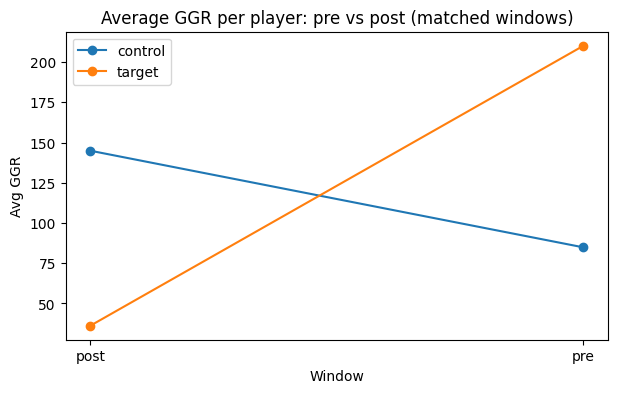

In [16]:
plot_df = player.groupby("target_control")[["ggr_pre", "ggr_post"]].mean().reset_index()
plot_df = plot_df.melt(id_vars="target_control", var_name="window", value_name="avg_ggr")

plot_df["window"] = plot_df["window"].replace({"ggr_pre":"pre", "ggr_post":"post"})

fig, ax = plt.subplots(figsize=(7,4))
for grp in ["control", "target"]:
    sub = plot_df[plot_df["target_control"] == grp].sort_values("window")
    ax.plot(sub["window"], sub["avg_ggr"], marker="o", label=grp)

ax.set_title("Average GGR per player: pre vs post (matched windows)")
ax.set_xlabel("Window")
ax.set_ylabel("Avg GGR")
ax.legend()
plt.show()

## Window-Matched Difference-in-Differences (DiD) ROI:

### 1) Analysis windows (matched length)
- **Post-promo window:** defined from rows where `post_promo == True` (**17 days total**).
- **Pre-promo window (matched):** defined as the **immediately preceding 17-day window** to ensure pre/post comparability and avoid bias from unequal window lengths.

### 2) Player-level metric construction (unit of analysis = player)
For each `player_id`, daily transaction rows are aggregated into per-window totals:
- `ggr_pre`, `ggr_post`: sum of `ggr` within pre/post windows  
- `handle_pre`, `handle_post`: sum of `handle` within pre/post windows  
- `active_days_pre`, `active_days_post`: number of distinct active dates per window  
This ensures target/control comparisons are performed consistently at the player level rather than being affected by different row counts or activity frequency.

### 3) Promotion cost (bonus) accounting — counted once per player
Promo spend is computed from the full dataset using **one bonus per customer**:
- `bonus_awarded_player = max(bonus_awarded) per player_id`, summed over **target** players only.
- **Total bonus cost (target):** **$1,480.00**  
This prevents undercounting promo cost by excluding targeted customers who received a bonus but did not place bets post-promo.

### 4) Primary causal estimate: Difference-in-Differences incremental GGR
Estimate incremental revenue attributable to the promo via DiD:

$$
\Delta = (GGR_{Target,post} - GGR_{Target,pre}) - (GGR_{Control,post} - GGR_{Control,pre})
$$

**Cohort sizes**
- Target players: **161**
- Control players: **41**

**Computed totals**
- Target: `GGR_pre = 33,834.16`, `GGR_post = 5,826.55`, **Δ_target = −28,007.61**
- Control: `GGR_pre = 3,479.52`, `GGR_post = 5,941.82`, **Δ_control = +2,462.30**
- **DiD incremental GGR (Δ):** **−30,469.91**  
Interpretation: after adjusting for the control group’s time trend, target performance decreased substantially in the post period relative to pre period.

**Uncertainty (bootstrap; resampling players with replacement)**
- **Δ mean (bootstrap):** **−30,426.89**
- **Δ 95% CI:** **[−73,972.01, 9,788.45]**

### 5) Primary ROI metric (DiD ROI)
We compute ROI as:

$$
ROI_{DiD} = \frac{\Delta - BonusCost}{BonusCost}
$$

- **BonusCost:** **$1,480.00**
- **Δ (DiD incremental GGR):** **−30,469.91**
- **DiD ROI:** **−21.5878**

**Uncertainty (bootstrap 95% CI)**
- **DiD ROI mean (bootstrap):** **−21.2803**
- **DiD ROI 95% CI:** **[−48.5005, 5.5371]**

### 6) Secondary (descriptive) metric: Naive post-only ROI (for context only)
A post-only ROI can be computed as `(GGR_post_target − BonusCost) / BonusCost`, but it is **descriptive** and not causal.

**Important note:** Naive ROI is sensitive to seasonality, regression-to-the-mean, and macro trends.  
**DiD ROI is the primary metric** because it adjusts for baseline differences and shared time trends using the control group.

## Segmentation & retention:

In [17]:
# --- Add segmentation attributes to player-level table ---

# Segment label at player level
player_seg = (
    df.groupby(["player_id", "target_control"], as_index=False)
      .agg(last_12months_segment=("last_12months_segment",
                                 lambda x: x.dropna().astype(str).str.strip().str.lower().mode().iloc[0]
                                           if x.dropna().any() else np.nan))
)

player = player.merge(player_seg, on=["player_id", "target_control"], how="left")

# derive a baseline 'handle_bin' from pre window totals (greater stability than row-level handle_bin)
BIN_LABELS = [
    "< $100",
    "$100–$499",
    "$500–$999",
    "$1,000–$1,499",
    "$1,500–$2,499",
    "$2,500–$3,499",
    "$3,500–$4,999",
    "$5,000–$9,999",
    "$10K–$24,999",
    "$25K–$49,999",
    "$50K–$99,999",
    "$100K–$199,999",
    "$200K–$299,999",
    "$300K–$399,999",
    "$400K+",
]

import re

def _to_num(s):
    return float(s.replace("$","").replace(",","").replace("K","000"))

def parse_bin(label):
    label = label.strip()
    if label.startswith("<"):
        hi = _to_num(re.findall(r"\$?([\d,]+)", label)[0])
        return (0.0, hi, label)
    if label.endswith("+"):
        lo = _to_num(re.findall(r"\$?([\d,]+K?)", label)[0])
        return (lo, np.inf, label)
    parts = re.split(r"[–-]", label)
    lo = _to_num(parts[0].strip())
    hi = _to_num(parts[1].strip())
    return (lo, hi, label)

BIN_RANGES = sorted([parse_bin(b) for b in BIN_LABELS], key=lambda x: x[0])

def assign_handle_bin(val):
    if pd.isna(val):
        return np.nan
    for lo, hi, lab in BIN_RANGES:
        if lo <= val < hi:
            return lab
    return BIN_RANGES[-1][2]

player["handle_bin_pre"] = player["handle_pre"].apply(assign_handle_bin)

player[["player_id","target_control","last_12months_segment","handle_bin_pre"]].head()

,player_id,target_control,last_12months_segment,handle_bin_pre
0,1128453,target,low,$100–$499
1,1128604,target,medium,$100–$499
2,1130293,target,low,"$3,500–$4,999"
3,1131401,target,medium,"$2,500–$3,499"
4,1132221,target,medium,< $100


In [18]:
# --- Segment-level DiD ROI: using matched windows ---

def safe_roi(did_inc_ggr, bonus_cost):
    return (did_inc_ggr - bonus_cost) / bonus_cost if bonus_cost and bonus_cost > 0 else np.nan

def segment_did_table(player_df, seg_col):
    rows = []
    for seg, sub in player_df.groupby(seg_col, dropna=False):
        if pd.isna(seg):
            continue

        t = sub[sub["target_control"] == "target"]
        c = sub[sub["target_control"] == "control"]
        if len(t) == 0 or len(c) == 0:
            continue

        t_pre, t_post = t["ggr_pre"].sum(), t["ggr_post"].sum()
        c_pre, c_post = c["ggr_pre"].sum(), c["ggr_post"].sum()

        did_inc_ggr = (t_post - t_pre) - (c_post - c_pre)
        bonus_cost = t["bonus_awarded"].sum()

        # additionally computing incremental handle + hold for diagnostic context
        did_inc_handle = (t["handle_post"].sum() - t["handle_pre"].sum()) - (c["handle_post"].sum() - c["handle_pre"].sum())

        roi = safe_roi(did_inc_ggr, bonus_cost)

        rows.append({
            seg_col: seg,
            "n_target": len(t),
            "n_control": len(c),
            "did_incremental_ggr": did_inc_ggr,
            "bonus_cost": bonus_cost,
            "did_roi": roi,
            "did_incremental_handle": did_inc_handle,
        })

    return pd.DataFrame(rows).sort_values(seg_col)

seg_tier = segment_did_table(player, "last_12months_segment")
seg_tier

,last_12months_segment,n_target,n_control,did_incremental_ggr,bonus_cost,did_roi,did_incremental_handle
0,high,15,3,-532.25,300.0,-2.774167,-28335.03
1,low,78,24,7047.23,390.0,17.069821,34660.41
2,medium,27,7,-13766.49,270.0,-51.987000,-130993.05
3,no bet,1,1,-25.12,5.0,-6.024000,-211.70
4,regnodep,33,5,-436.34,165.0,-3.644485,-11837.42
5,vip,7,1,-22756.94,350.0,-66.019829,404416.46


In [19]:
# --- Bootstrap CIs per segment: player-resampling w/in segment & group ---

def bootstrap_segment(player_df, seg_col, seg_value, n=2000, seed=42):
    rng = np.random.default_rng(seed)

    sub = player_df[player_df[seg_col] == seg_value]
    t = sub[sub["target_control"] == "target"]
    c = sub[sub["target_control"] == "control"]
    if len(t) == 0 or len(c) == 0:
        return None

    incs, rois = [], []

    for _ in range(n):
        t_s = t.sample(frac=1, replace=True, random_state=int(rng.integers(0, 1e9)))
        c_s = c.sample(frac=1, replace=True, random_state=int(rng.integers(0, 1e9)))

        did_inc = (t_s["ggr_post"].sum() - t_s["ggr_pre"].sum()) - (c_s["ggr_post"].sum() - c_s["ggr_pre"].sum())
        bonus = t_s["bonus_awarded"].sum()
        roi = safe_roi(did_inc, bonus)

        incs.append(did_inc)
        rois.append(roi)

    incs = np.array(incs, dtype=float)
    rois = np.array(rois, dtype=float)

    return {
        "did_inc_ci95_low": np.nanpercentile(incs, 2.5),
        "did_inc_ci95_high": np.nanpercentile(incs, 97.5),
        "did_roi_ci95_low": np.nanpercentile(rois, 2.5),
        "did_roi_ci95_high": np.nanpercentile(rois, 97.5),
    }

# attaching CIs to tier table
ci_rows = []
for seg in seg_tier["last_12months_segment"]:
    ci = bootstrap_segment(player, "last_12months_segment", seg, n=2000, seed=42)
    ci_rows.append({"last_12months_segment": seg, **ci})

seg_tier_ci = seg_tier.merge(pd.DataFrame(ci_rows), on="last_12months_segment", how="left")
seg_tier_ci

,last_12months_segment,n_target,n_control,did_incremental_ggr,bonus_cost,did_roi,did_incremental_handle,did_inc_ci95_low,did_inc_ci95_high,did_roi_ci95_low,did_roi_ci95_high
0,high,15,3,-532.25,300.0,-2.774167,-28335.03,-9911.06125,9017.36725,-34.036871,29.057891
1,low,78,24,7047.23,390.0,17.069821,34660.41,-4744.79725,25712.78225,-13.166147,64.930211
2,medium,27,7,-13766.49,270.0,-51.987000,-130993.05,-36182.43175,1462.30000,-135.009006,4.415926
3,no bet,1,1,-25.12,5.0,-6.024000,-211.70,-25.12000,-25.12000,-6.024000,-6.024000
4,regnodep,33,5,-436.34,165.0,-3.644485,-11837.42,-676.83525,-203.47750,-5.102032,-2.233197
5,vip,7,1,-22756.94,350.0,-66.019829,404416.46,-51819.95000,1821.57075,-149.057000,4.204488


In [20]:
seg_tier_ci["net_after_bonus"] = seg_tier_ci.apply(
    lambda r: net_after_bonus(r["did_incremental_ggr"], r["bonus_cost"]),
    axis=1
)

seg_tier_ci

,last_12months_segment,n_target,n_control,did_incremental_ggr,bonus_cost,did_roi,did_incremental_handle,did_inc_ci95_low,did_inc_ci95_high,did_roi_ci95_low,did_roi_ci95_high,net_after_bonus
0,high,15,3,-532.25,300.0,-2.774167,-28335.03,-9911.06125,9017.36725,-34.036871,29.057891,-832.25
1,low,78,24,7047.23,390.0,17.069821,34660.41,-4744.79725,25712.78225,-13.166147,64.930211,6657.23
2,medium,27,7,-13766.49,270.0,-51.987000,-130993.05,-36182.43175,1462.30000,-135.009006,4.415926,-14036.49
3,no bet,1,1,-25.12,5.0,-6.024000,-211.70,-25.12000,-25.12000,-6.024000,-6.024000,-30.12
4,regnodep,33,5,-436.34,165.0,-3.644485,-11837.42,-676.83525,-203.47750,-5.102032,-2.233197,-601.34
5,vip,7,1,-22756.94,350.0,-66.019829,404416.46,-51819.95000,1821.57075,-149.057000,4.204488,-23106.94


In [21]:
# --- Retention / attrition diagnostics by segment & group ---

def retention_block(g):
    # share active in each window
    share_pre = g["active_pre"].mean()
    share_post = g["active_post"].mean()

    # retention among pre-actives
    pre_actives = g[g["active_pre"]]
    retention = pre_actives["active_post"].mean() if len(pre_actives) > 0 else np.nan

    # reactivation among pre-inactives
    pre_inactives = g[~g["active_pre"]]
    reactivation = pre_inactives["active_post"].mean() if len(pre_inactives) > 0 else np.nan

    return pd.Series({
        "n_players": len(g),
        "share_active_pre": share_pre,
        "share_active_post": share_post,
        "retention_pre_to_post": retention,
        "reactivation": reactivation,
        "avg_active_days_pre": g["active_days_pre"].mean(),
        "avg_active_days_post": g["active_days_post"].mean(),
    })

ret_by_tier = (
    player.groupby(["last_12months_segment", "target_control"])
          .apply(retention_block)
          .reset_index()
)

ret_by_tier

/var/folders/cz/dgb3tl0j0dv_z900spvfm6p40000gn/T/ipykernel_16695/2293034838.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  player.groupby(["last_12months_segment", "target_control"])


,last_12months_segment,target_control,n_players,share_active_pre,share_active_post,retention_pre_to_post,reactivation,avg_active_days_pre,avg_active_days_post
0,high,control,3.0,1.000000,1.000000,1.000000,NaN,6.000000,7.000000
1,high,target,15.0,0.800000,0.933333,0.916667,1.0,8.133333,7.800000
2,low,control,24.0,0.833333,0.750000,0.700000,1.0,2.541667,2.291667
3,low,target,78.0,0.820513,0.666667,0.593750,1.0,3.205128,3.294872
4,medium,control,7.0,1.000000,1.000000,1.000000,NaN,10.714286,7.857143
5,medium,target,27.0,0.925926,0.814815,0.800000,1.0,5.925926,4.296296
6,no bet,control,1.0,0.000000,1.000000,NaN,1.0,0.000000,1.000000
7,no bet,target,1.0,0.000000,1.000000,NaN,1.0,0.000000,1.000000
8,regnodep,control,5.0,0.400000,0.800000,0.500000,1.0,0.400000,1.000000
9,regnodep,target,33.0,0.757576,0.242424,0.000000,1.0,0.939394,0.363636


In [22]:
# --- Retention / Attrition decomposition (pre vs post, matched windows) ---

def attrition_decomposition(p, group_cols):
    d = p.copy()

    d["status"] = np.select(
        [
            d["active_pre"] & d["active_post"],
            d["active_pre"] & ~d["active_post"],
            ~d["active_pre"] & d["active_post"],
            ~d["active_pre"] & ~d["active_post"],
        ],
        ["retained", "churned", "reactivated", "inactive_both"],
        default="unknown"
    )

    out = (d.groupby(group_cols + ["status"])
             .size()
             .reset_index(name="n_players"))

    # convert to shares within group
    totals = out.groupby(group_cols)["n_players"].transform("sum")
    out["share_players"] = out["n_players"] / totals
    return out.sort_values(group_cols + ["status"])

attr_tier = attrition_decomposition(
    player,
    group_cols=["last_12months_segment", "target_control"]
)

attr_tier

,last_12months_segment,target_control,status,n_players,share_players
0,high,control,retained,3,1.000000
1,high,target,churned,1,0.066667
2,high,target,reactivated,3,0.200000
3,high,target,retained,11,0.733333
4,low,control,churned,6,0.250000
5,low,control,reactivated,4,0.166667
6,low,control,retained,14,0.583333
7,low,target,churned,26,0.333333
8,low,target,reactivated,14,0.179487
9,low,target,retained,38,0.487179


In [23]:
attr_tier_pivot = (attr_tier
                   .pivot_table(index=["last_12months_segment","target_control"],
                                columns="status",
                                values="share_players",
                                fill_value=0)
                   .reset_index())

attr_tier_pivot

status,last_12months_segment,target_control,churned,reactivated,retained
0,high,control,0.000000,0.000000,1.000000
1,high,target,0.066667,0.200000,0.733333
2,low,control,0.250000,0.166667,0.583333
3,low,target,0.333333,0.179487,0.487179
4,medium,control,0.000000,0.000000,1.000000
5,medium,target,0.185185,0.074074,0.740741
6,no bet,control,0.000000,1.000000,0.000000
7,no bet,target,0.000000,1.000000,0.000000
8,regnodep,control,0.200000,0.600000,0.200000
9,regnodep,target,0.757576,0.242424,0.000000


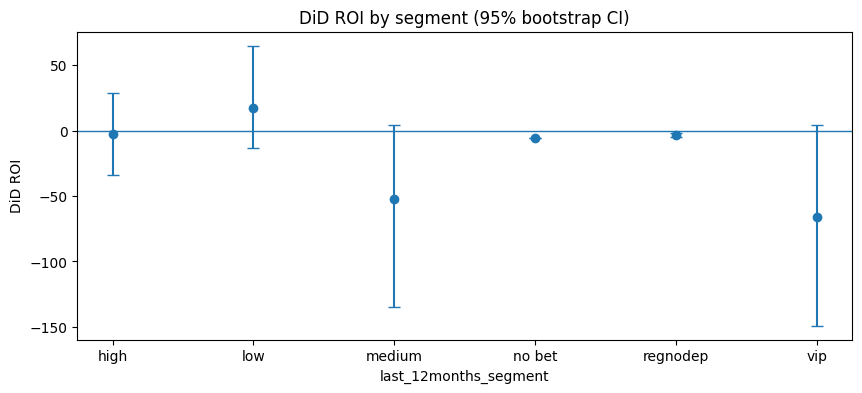

In [24]:
# --- Plotting segment DiD ROI with CI error bars ---

plot = seg_tier_ci.copy()
plot["roi_err_low"] = plot["did_roi"] - plot["did_roi_ci95_low"]
plot["roi_err_high"] = plot["did_roi_ci95_high"] - plot["did_roi"]

fig, ax = plt.subplots(figsize=(10, 4))
ax.errorbar(
    x=np.arange(len(plot)),
    y=plot["did_roi"],
    yerr=[plot["roi_err_low"], plot["roi_err_high"]],
    fmt="o",
    capsize=4
)

ax.axhline(0, linewidth=1)
ax.set_xticks(np.arange(len(plot)))
ax.set_xticklabels(plot["last_12months_segment"], rotation=0)
ax.set_title("DiD ROI by segment (95% bootstrap CI)")
ax.set_ylabel("DiD ROI")
ax.set_xlabel("last_12months_segment")
plt.show()

## Executive Recommendations (Segmented DiD + Retention Diagnostics)

### Summary: What the segmentation shows
Using the same **matched 17-day pre/post windows**, we computed **segment-level Difference-in-Differences (DiD) ROI** and paired it with **retention/reactivation diagnostics**. Overall, the segment results are heterogeneous, with one segment showing upside in point estimates (“low”), several segments showing strongly negative point estimates, and one segment (“regnodep”) showing **consistently negative ROI with a CI entirely below 0** (which is the strongest evidence of harm).

---

### A) Primary decision: Where to scale vs. stop

#### 1) **STOP / EXCLUDE: `regnodep` (strong evidence sportsbook promo is harmful)**
- **DiD incremental GGR:** **−$436.34** on **$165** bonus spend.
- **DiD ROI:** **−3.64** with **95% CI [−5.10, −2.23]** → CI is entirely negative (highest confidence “do not run” segment).
- **Behavioral diagnostics (target):**
  - Share active falls **0.758 → 0.242**.
  - **Retention (pre→post) = 0.00** (none of the pre-active target players remained active in post).
  - Avg active days collapses **0.94 → 0.36**.
- **Interpretation:** This segment is not only unprofitable, but also the promo correlates with a sharp drop in post activity after controlling for trend via the control group.  
✅ **Recommendation:** Remove `regnodep` from eligibility immediately (or redesign offer mechanics specifically for this cohort).

---

#### 2) **PRIORITIZE FOR FOLLOW-UP TEST: `low` (best upside, but not statistically conclusive)**
- **DiD incremental GGR:** **+$7,047.23** on **$390** bonus spend.
- **DiD ROI:** **+17.07** with **95% CI [−13.17, +64.93]** → point estimate strongly positive, CI crosses 0.
- **Handle response:** **+34,660** incremental handle (volume increases).
- **Behavioral diagnostics:**
  - Target share active declines **0.821 → 0.667**; retention among pre-actives **0.594**.
  - Control retention is higher (**0.700**) → promo does not clearly improve retention.
- **Interpretation:** The segment shows the *only* clear positive incremental GGR signal, but uncertainty remains (CI crosses 0) and retention does not improve.  
✅ **Recommendation:** Keep this segment as the **primary candidate to re-test/scale**, but do it as a cleaner experiment:
  - Longer post window (e.g., 4–6 weeks) or more samples.
  - Add guardrails: net GGR after bonus, retention lift, and abuse signals.

---

#### 3) **PAUSE / REDESIGN: `medium` and `vip` (large negative point estimates; likely margin deterioration)**
**`medium`**
- **DiD incremental GGR:** **−$13,766.49** on **$270** spend  .
- **DiD ROI:** **−51.99** with **95% CI [−135.01, +4.42]**.
- **Handle response:** **−130,993** incremental handle (volume down sharply).
- **Behavioral diagnostics:** target share active declines **0.926 → 0.815**, avg active days drop **5.93 → 4.30**.

✅ **Recommendation:** Pause.
This looks like a true negative effect (big negative ROI), though CI barely crosses 0.
Re-run only with redesigned offer and/or different eligibility.

**`vip`**
- **DiD incremental GGR:** **−$22,756.94** on **$350** spend.
- **DiD ROI:** **−66.02** with **95% CI [−149.06, +4.20]** (very wide due to tiny control).
- **Handle response:** **+404,416** incremental handle **while** GGR is very negative.
  → suggests **volume without margin** (e.g., promo-chasing, adverse selection, or hold-rate collapse)

✅ **Recommendation:** Do not scale as-is. If VIP promos are required, rework the mechanism (e.g., wager requirements, tiered rewards based on net revenue, stronger abuse prevention), and validate with a properly sized control.

---

#### 4) **DE-PRIORITIZE / MONITOR: `high`**
- **DiD ROI:** **−2.77** with **95% CI [−34.04, +29.06]** (high uncertainty, small sample)
- Retention does not show a clear positive shift vs control.

✅ **Recommendation:** Do not scale without more evidence. If kept, treat as “exploratory” only.

---

#### 5) **INSUFFICIENT SAMPLE: `no bet`**
- n is **1 target / 1 control** → not actionable.

✅ **Recommendation:** Exclude from decisioning until sample size is meaningful.

---

### B) What the retention table adds (beyond ROI)
Across multiple segments, the promo **does not reliably increase retention**:
- In `low`, retention among pre-actives is **0.594 target vs 0.700 control** (promo not improving persistence).
- In `regnodep`, retention collapses to **0.00** for target (strong negative behavioral signal).
- In `medium`, target activity declines post even as control remains stable.

✅ **Recommendation:** In addition to ROI, treat **retention lift** and **active-days lift** as explicit success metrics for promo qualification.

---

### C) Action plan (what to do next)
1) **Immediately exclude `regnodep`** from promo eligibility (highest-confidence negative ROI + retention collapse).
2) **Run a follow-up experiment focused on `low`** segment:
   - Extend measurement window (≥ 4 weeks).
   - Track: DiD incremental GGR, net GGR after bonus, retention/active days, and abuse indicators.
3) **Redesign offers for `vip` and `medium`** before retesting:
   - VIP: reduce margin risk (wagering requirements, tiered rewards, payout caps, or net-revenue-based incentives).
   - Medium: reassess eligibility and offer mechanics; current signal indicates possible cannibalization or disengagement.
4) **Improve statistical power**:
   - Several segments have very small control groups; widen sampling or rebalance assignment so segment-level CIs become decision-grade.

---

### D) Key caveats (what can and cannot be claimed)
- Segment-level results are sensitive to **small sample sizes**, especially in `vip`, `high`, and `no bet`.
- Despite uncertainty in many segments, `regnodep` is the clearest actionable finding because its ROI CI is **entirely below 0** and the retention behavior strongly corroborates harm.
- Conclusions should be interpreted as **incremental effects within matched windows** (DiD), not as long-term LTV impacts.

In [25]:
# --- CRM decision table (segment read-out) ---

# Segment DiD table with CIs
crm = seg_tier_ci.copy()

# Ensure net-after-bonus is present
if "net_after_bonus" not in crm.columns:
    crm["net_after_bonus"] = crm["did_incremental_ggr"] - crm["bonus_cost"]

# Attrition decomposition shares (retained/churned/reactivated/inactive_both)
if "attr_tier_pivot" in globals():
    attr_piv = attr_tier_pivot.copy()
else:
    attr_piv = (attr_tier
                .pivot_table(index=["last_12months_segment","target_control"],
                             columns="status",
                             values="share_players",
                             fill_value=0)
                .reset_index())

# Keeping only target attrition shares (as CRM team's action is focused on this population)
attr_target = attr_piv[attr_piv["target_control"] == "target"].drop(columns=["target_control"])

crm = crm.merge(attr_target, on="last_12months_segment", how="left")

# Simple "confidence" label from CI
def confidence_label(row):
    lo, hi = row["did_roi_ci95_low"], row["did_roi_ci95_high"]
    if pd.isna(lo) or pd.isna(hi):
        return "unknown"
    if lo > 0:
        return "confident_positive"
    if hi < 0:
        return "confident_negative"
    return "uncertain"

crm["roi_confidence"] = crm.apply(confidence_label, axis=1)

# CRM-friendly decision rules
def crm_call(row):
    n_t, n_c = row["n_target"], row["n_control"]
    lo, hi = row["did_roi_ci95_low"], row["did_roi_ci95_high"]

    # case for when there is not big enough samples (extremely small groups)
    if (n_t < 10) or (n_c < 5):
        return "INSUFFICIENT DATA"

    if lo > 0:
        return "SCALE"
    if hi < 0:
        return "STOP"
    return "HOLD / RETEST"

crm["crm_call"] = crm.apply(crm_call, axis=1)

cols = [
    "last_12months_segment",
    "n_target", "n_control",
    "did_incremental_ggr", "did_inc_ci95_low", "did_inc_ci95_high",
    "bonus_cost", "net_after_bonus",
    "did_roi", "did_roi_ci95_low", "did_roi_ci95_high",
    "roi_confidence",
    "retained", "churned", "reactivated", "inactive_both",
    "crm_call",
]

cols = [c for c in cols if c in crm.columns]

crm_out = crm[cols].copy()

num_cols = [c for c in crm_out.columns if c not in ["last_12months_segment","roi_confidence","crm_call"]]
crm_out[num_cols] = crm_out[num_cols].apply(pd.to_numeric, errors="ignore")

crm_out = crm_out.sort_values(["crm_call","last_12months_segment"])
crm_out

/var/folders/cz/dgb3tl0j0dv_z900spvfm6p40000gn/T/ipykernel_16695/305083122.py:72: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  crm_out[num_cols] = crm_out[num_cols].apply(pd.to_numeric, errors="ignore")


,last_12months_segment,n_target,n_control,did_incremental_ggr,did_inc_ci95_low,did_inc_ci95_high,bonus_cost,net_after_bonus,did_roi,did_roi_ci95_low,did_roi_ci95_high,roi_confidence,retained,churned,reactivated,crm_call
1,low,78,24,7047.23,-4744.79725,25712.78225,390.0,6657.23,17.069821,-13.166147,64.930211,uncertain,0.487179,0.333333,0.179487,HOLD / RETEST
2,medium,27,7,-13766.49,-36182.43175,1462.30000,270.0,-14036.49,-51.987000,-135.009006,4.415926,uncertain,0.740741,0.185185,0.074074,HOLD / RETEST
0,high,15,3,-532.25,-9911.06125,9017.36725,300.0,-832.25,-2.774167,-34.036871,29.057891,uncertain,0.733333,0.066667,0.200000,INSUFFICIENT DATA
3,no bet,1,1,-25.12,-25.12000,-25.12000,5.0,-30.12,-6.024000,-6.024000,-6.024000,confident_negative,0.000000,0.000000,1.000000,INSUFFICIENT DATA
5,vip,7,1,-22756.94,-51819.95000,1821.57075,350.0,-23106.94,-66.019829,-149.057000,4.204488,uncertain,0.857143,0.142857,0.000000,INSUFFICIENT DATA
4,regnodep,33,5,-436.34,-676.83525,-203.47750,165.0,-601.34,-3.644485,-5.102032,-2.233197,confident_negative,0.000000,0.757576,0.242424,STOP


In [26]:
# --- CRM notes / playbook guidance per segment: ---

def crm_notes(row):
    seg = row["last_12months_segment"]
    call = row["crm_call"]

    if seg == "regnodep":
        return ("STOP: statistically negative ROI (CI entirely < 0) and severe churn in target. "
                "Remove from eligibility; if required, redesign offer with tighter conditions and abuse controls.")
    if seg == "low":
        return ("HOLD/RETEST (or limited scale): best upside point estimate, but CI crosses 0. "
                "Run larger/longer test; monitor net-after-bonus, retention, and abuse indicators.")
    if seg == "vip":
        return ("HOLD/RETEST: large negative ROI point estimate and very wide CI due to tiny control. "
                "If offering VIP promos, redesign to protect margin (wager requirements/tiered rewards) and increase control size.")
    if seg == "medium":
        return ("STOP or REDESIGN: very negative ROI point estimate with handle also down. "
                "Reassess targeting and promo mechanics before re-running.")
    if seg == "high":
        return ("HOLD/RETEST: small sample and ROI uncertain. "
                "Increase sample or run longer window before making rollout decisions.")
    if seg == "no bet":
        return ("INSUFFICIENT DATA: too few users. Exclude from decisioning until sample size is meaningful.")

    if call == "SCALE":
        return ("SCALE: ROI CI is fully positive. Expand rollout and keep guardrails on net-after-bonus and retention.")
    if call == "STOP":
        return ("STOP: ROI CI is fully negative. Remove from eligibility or redesign.")
    if call == "HOLD / RETEST":
        return ("HOLD/RETEST: ROI is uncertain (CI crosses 0). Increase sample/extend window and validate with guardrails.")
    return "INSUFFICIENT DATA: not decision-grade."

crm_out["crm_notes"] = crm_out.apply(crm_notes, axis=1)
crm_out

,last_12months_segment,n_target,n_control,did_incremental_ggr,did_inc_ci95_low,did_inc_ci95_high,bonus_cost,net_after_bonus,did_roi,did_roi_ci95_low,did_roi_ci95_high,roi_confidence,retained,churned,reactivated,crm_call,crm_notes
1,low,78,24,7047.23,-4744.79725,25712.78225,390.0,6657.23,17.069821,-13.166147,64.930211,uncertain,0.487179,0.333333,0.179487,HOLD / RETEST,HOLD/RETEST (or limited scale): best upside po...
2,medium,27,7,-13766.49,-36182.43175,1462.30000,270.0,-14036.49,-51.987000,-135.009006,4.415926,uncertain,0.740741,0.185185,0.074074,HOLD / RETEST,STOP or REDESIGN: very negative ROI point esti...
0,high,15,3,-532.25,-9911.06125,9017.36725,300.0,-832.25,-2.774167,-34.036871,29.057891,uncertain,0.733333,0.066667,0.200000,INSUFFICIENT DATA,HOLD/RETEST: small sample and ROI uncertain. I...
3,no bet,1,1,-25.12,-25.12000,-25.12000,5.0,-30.12,-6.024000,-6.024000,-6.024000,confident_negative,0.000000,0.000000,1.000000,INSUFFICIENT DATA,INSUFFICIENT DATA: too few users. Exclude from...
5,vip,7,1,-22756.94,-51819.95000,1821.57075,350.0,-23106.94,-66.019829,-149.057000,4.204488,uncertain,0.857143,0.142857,0.000000,INSUFFICIENT DATA,HOLD/RETEST: large negative ROI point estimate...
4,regnodep,33,5,-436.34,-676.83525,-203.47750,165.0,-601.34,-3.644485,-5.102032,-2.233197,confident_negative,0.000000,0.757576,0.242424,STOP,STOP: statistically negative ROI (CI entirely ...


In [27]:
# --- Export CRM table ---

import os
os.makedirs("outputs", exist_ok=True)

crm_out.to_csv("outputs/crm_segment_recommendations.csv", index=False)
print("Saved: outputs/crm_segment_recommendations.csv")

Saved: outputs/crm_segment_recommendations.csv


## CRM Segment Read-Outs & Recommended Actions:

This portions converts the segmented DiD analysis into an actionable CRM playbook. Each segment is assigned a rollout decision based on:
- **DiD ROI point estimate + 95% bootstrap CI**
- **Net-after-bonus** (ΔGGR − BonusCost)
- **Target-side retention/attrition behavior** (retained/churned/reactivated shares)
- **Minimum sample thresholds** for decision-grade guidance

### Decision rules
- **SCALE**: ROI 95% CI lower bound > 0  
- **STOP**: ROI 95% CI upper bound < 0  
- **HOLD / RETEST**: CI crosses 0 (uncertain)  
- **INSUFFICIENT DATA**: sample too small (default: n_target < 10 or n_control < 5)

### Output artifact
- `outputs/crm_segment_recommendations.csv` — Found in this location is a shareable, CRM-ready table including segment metrics, uncertainty, attrition shares, and recommended action.

## End of analysis.